# 6. Spore Clusters

## Numerical experiments - Week 08/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using Revise
using CurveFit

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting

## 1. Spore centroid generation

The following code computes the coordinates of a cluster of $n$ spherical spores, placing one spore at the centre of the lattice and the rest of the spores distributed evenly around it - in polar, triangular, tetrahedral, cubic, octahedral and icosahedral configurations.

In [4]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

spore_centers = setup_spore_cluster(12, L, spore_rad)

13-element Vector{Tuple{Float64, Float64, Float64}}:
 (12.5, 12.5, 12.5)
 (12.5, 9.871344439404332, 16.7532540417602)
 (12.5, 9.871344439404332, 8.2467459582398)
 (12.5, 15.128655560595668, 8.2467459582398)
 (16.7532540417602, 12.5, 15.128655560595668)
 (16.7532540417602, 12.5, 9.871344439404332)
 (8.2467459582398, 12.5, 9.871344439404332)
 (8.2467459582398, 12.5, 15.128655560595668)
 (15.128655560595668, 16.7532540417602, 12.5)
 (9.871344439404332, 16.7532540417602, 12.5)
 (9.871344439404332, 8.2467459582398, 12.5)
 (15.128655560595668, 8.2467459582398, 12.5)
 (12.5, 15.128655560595668, 16.7532540417602)

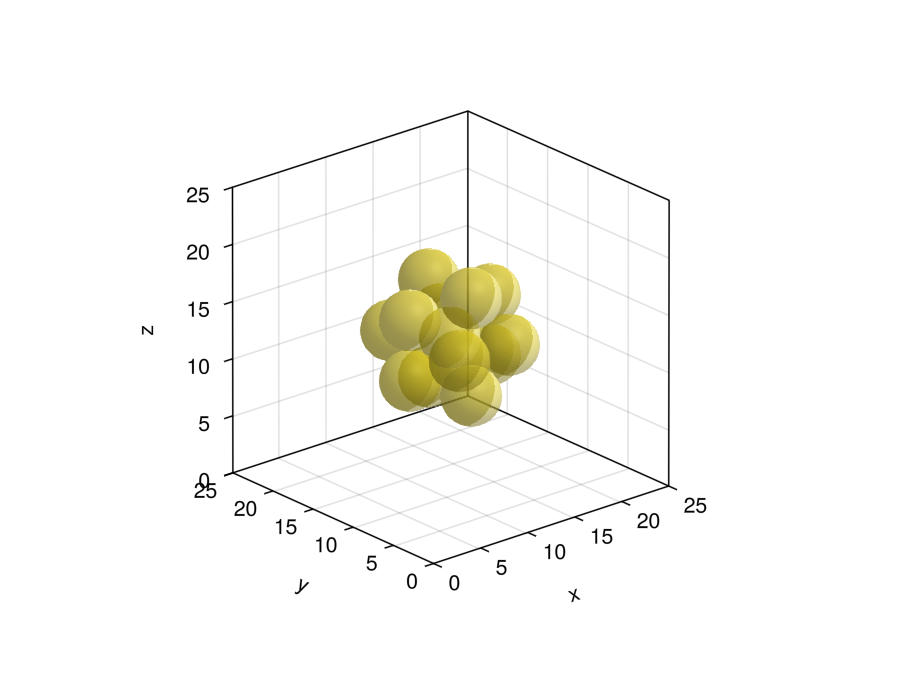

Makie.Axis3()

In [5]:
plot_spheres!(spore_centers, spore_rad, L, inline=true, title="Cluster of $(size(spore_centers)[1]) spores")

## 2. Measure of spore exposure

To measure the degree of coverage of a spore, a geometric construction is used that projects the areas of the surrounding spheres onto the central spore surface, here denoted as the sampling sphere, or sphere A. Let sphere B be a second reference sphere, with a centre positioned at a distance $d$ from the sampling sphere. One can construct a cone with a tip at the centre of the sphere A that touches sphere B tangentially. It thus intersects sphere A at a circular region, forming a spherical cap. The area of this cap can be computed by an integral over polar coordinates with a reference to the axis connecting the cenres of the two spheres:

$$
\begin{equation}
A=R^2\int_0^{2\pi}{\int_0^{\phi_0}{\sin{\phi}d{\phi}}d{\theta}},
\end{equation}
$$

where $\phi_0$ is the half-angle at the tip of the cone and defines the maximum that the vertical angle $\phi$ can reach and $\theta$ is the azimuthal angle around the reference axis. It can be noted that the farther sphere B is, the smaller its projection represented through the cap area would be. One can think of this projection as the "shadow" of sphere B onto sphere A. To capture even more detail about the proximity of surrounding spheres to the sampling sphere, each infinitesimal unit of area can be weighted by a function that depends on the projection distance between the surface areas. This can be pictured as the distance between two intersection points of a ray emanating from the centre of sphere A toward the sampled infinitesimal volume - one intersection through the surface of A and one through the surface of B. This distance can be expressed through the formula

$$
\begin{equation}
\Delta=d\cos{\phi}-\sqrt{R^2-d^2\sin^2{\phi}}-R
\end{equation}
$$

and used in a weighting function $w{(\phi)}=e^{-\Delta{(\phi)}}$, such that a weighted cap area is attained:

$$
\begin{equation}
A_w=R^2\int_0^{2\pi}{\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}d{\theta}}.
\end{equation}
$$

This has the property that the "shadow" intensity becomes 1 at $\Delta=0$ and decays to zero with increasing distance. Since the integrand is independent of the azimuthal angle $\theta$, the integral simplifies to

$$
\begin{equation}
A_w=2\pi R^2\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}.
\end{equation}
$$

The maximum limit for $\phi$ can be computed as $\phi_0=\arcsin{\frac{R}{d}}$. Thus, writing out the complete integral and summing for $M$ neighbours, one can obtain a measure for the surface coverage of a spore:

$$
\begin{equation}
Q=2\pi R^2\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}},
\end{equation}
$$

where $d_i$ are the corresponding distances from the sampling sphere centre to the neighbour centres. Furthermore, the cumulative surface coverage can be made relative to the total surface area of the spore by dividing by $4\pi R^2$:

$$
\begin{equation}
Q=\frac{1}{2}\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}}.
\end{equation}
$$

It is hereby assumed that only spheres that have an unobstructed "field of view" from the sampling sphere are considered. In the current experiments, these are furthermore only spheres that are directly adjacent to the central sphere.

The measure of coverage $Q$ is computed using the Julia `QuadGK` package and is demonstrated for different neighbour configurations.

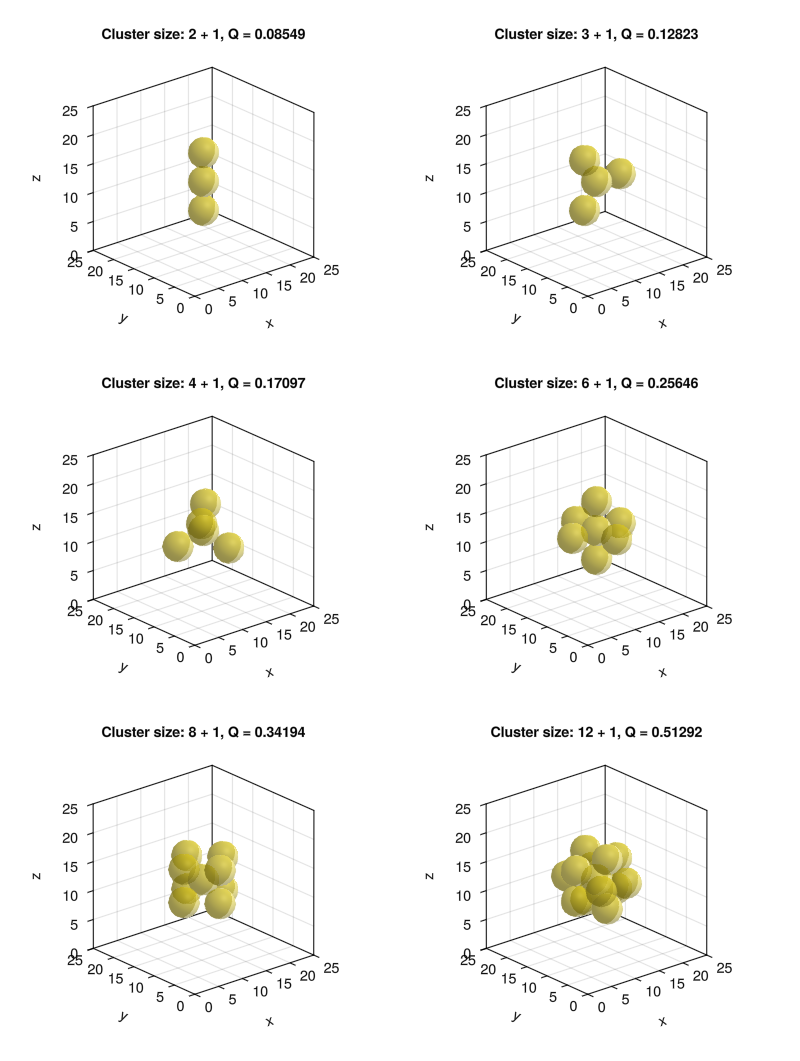

GLMakie.Screen(...)

In [4]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

n_nbrs = [2, 3, 4, 6, 8, 12]

plot_spore_clusters(n_nbrs, spore_rad, L)

Apart from the fully symmetrical neighbour configurations, asymmetrical arrangements of the spores are also investigated by omitting all spores in the upper half-space of the cluster. Apart from implementing neighbourhood counts which were not possible in the regular clusters, this is helpful for verifying whether the same number of neighbours in a symmetrical and an asymmetrical arrangement has the same influence on diffusion inhibition.

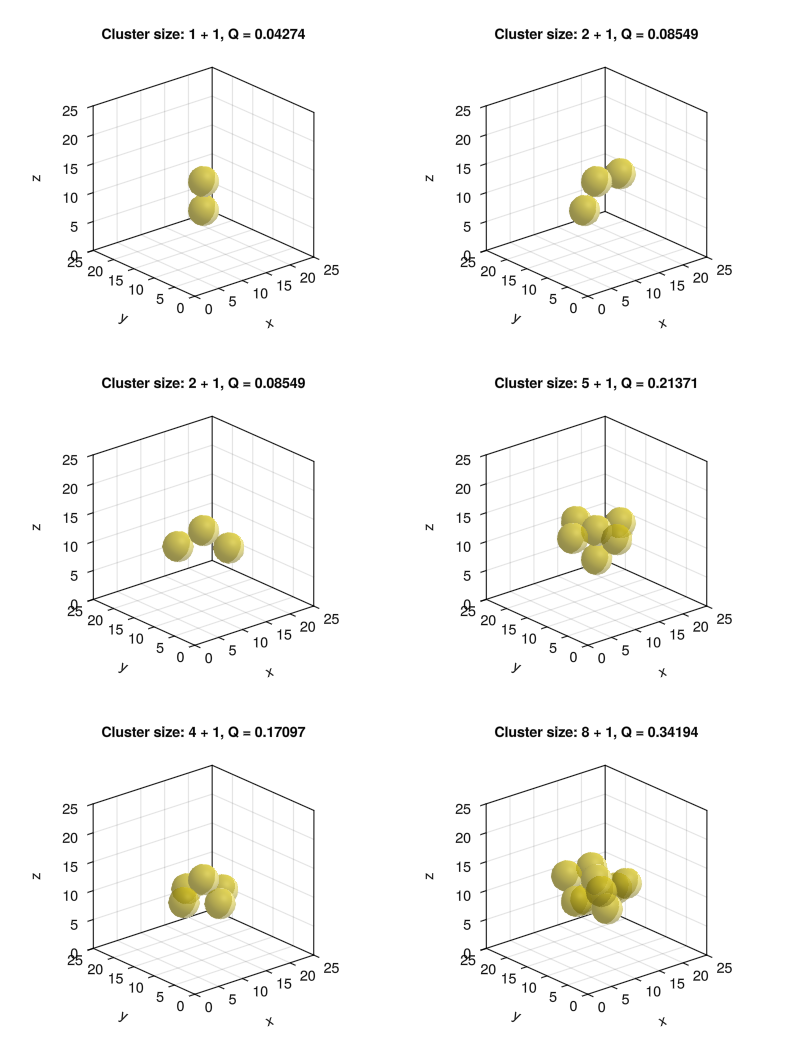

GLMakie.Screen(...)

In [5]:
plot_spore_clusters(n_nbrs, spore_rad, L; cut_half=true)

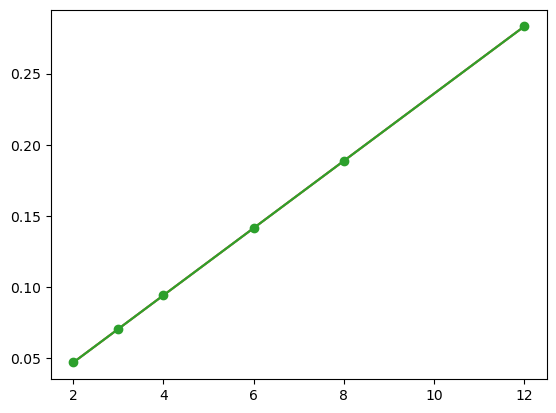

In [15]:
plot([2,3,4,6,8,12],[0.04717,0.07075,0.09434,0.1415,0.18867,0.28301], marker="o")
gcf()

## 3. Diffusion test

A diffusion process in a multi-spore cluster is briefly demonstrated in a linear cluster of 3 for a time-frame of 100 seconds. An absorbing boundary condition is defined, such that the concentrations at the edges of the domain are always zero. The lattice size is set to $128\times 0.2\mu m$.

In [6]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100 # s
c0_spore = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long
# dx = 0.4

# Diffusion parameters
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

# Spore centers
sp_cen_indices = setup_spore_cluster(2, N, spore_rad / dx + 0.5, false) # with safety radius of 0.5
println("Spore centers: ", sp_cen_indices)

# Run simulation
n_save_frames = 100
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D^2, Db=Db, dt=dt, dx=dx, #corr_factor=0.65,
                                                                        n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=false, nondim=true)
println("Numerical solution (high-resolution): ", c_numerical[end])

Spore centers: [(64, 64, 64), (64, 64, 90), (64, 64, 38)]
Spore radius in lattice units: 12.5
Parameters rescaled to D = 360000, Db = 1.486307260839899e-10, dt = 720.0, dx = 0.04, t_max = 1.44e6
Using D = 360000, Db = 9.908715072265993e-11, Dcw = 9.908715072265993e-11
D*dt/dx2 = 1.62e11, Db*dt/dx2 = 4.458921782519697e-5, Dcw*dt/dx2 = 4.458921782519697e-5
Timescale for accuracy: 4.444444444444444e-9
Storage arrays allocated.
1.5
Frame 1 saved.1.4995237588882449
Frame 2 saved.1.4990487098693845
Frame 3 saved.1.4985734224319458
Frame 4 saved.1.4980967044830318
Frame 5 saved.1.497621774673462
Frame 6 saved.1.4971446990966797
Frame 7 saved.1.4966684579849243
Frame 8 saved.1.4961929321289058
Frame 9 saved.1.4957175254821775
Frame 10 saved.1.4952418804168703
Frame 11 saved.1.494767189025879
Frame 12 saved.1.494291543960571
Frame 13 saved.1.4938182830810545
Frame 14 saved.1.4933437108993528
Frame 15 saved.1.4928694963455205
Frame 16 saved.1.4923957586288454
Frame 17 saved.1.4919215440750118
Fr

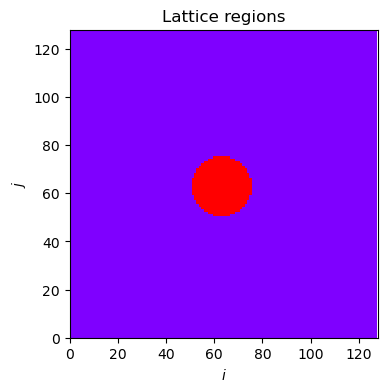

In [4]:
plot_lattice_regions(region_ids)

Plotting frames: [1, 26, 51, 76]


sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


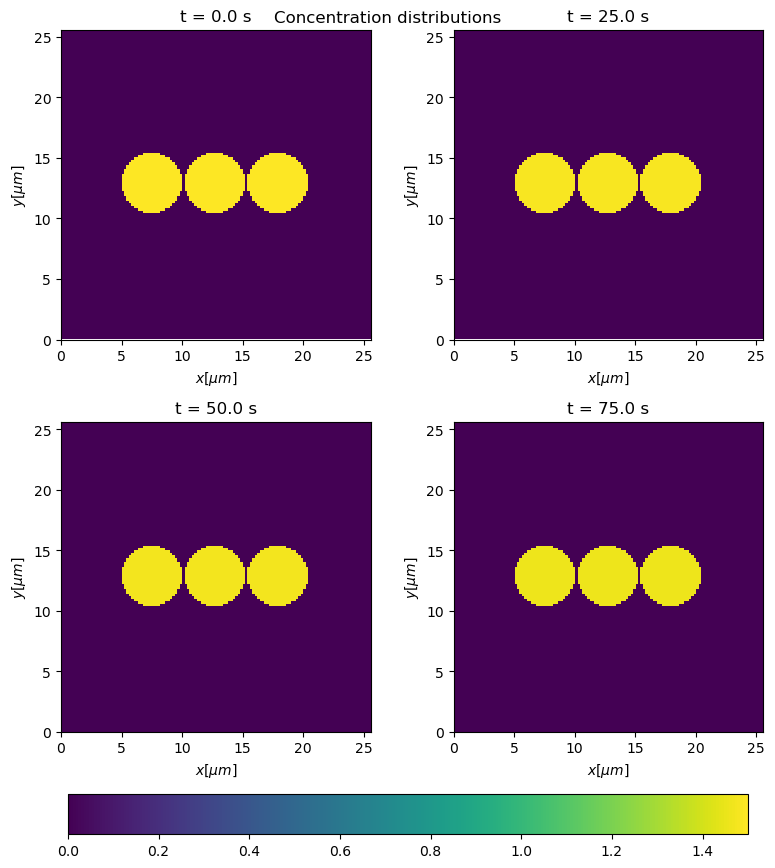

In [7]:
frame_indices = collect(1:round(Int, size(c_frames)[1] / 4):size(c_frames)[1]-1)
plot_concentration_lattice(c_frames, dx, frame_indices=frame_indices, times=times_numerical, title="Concentration distributions")

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


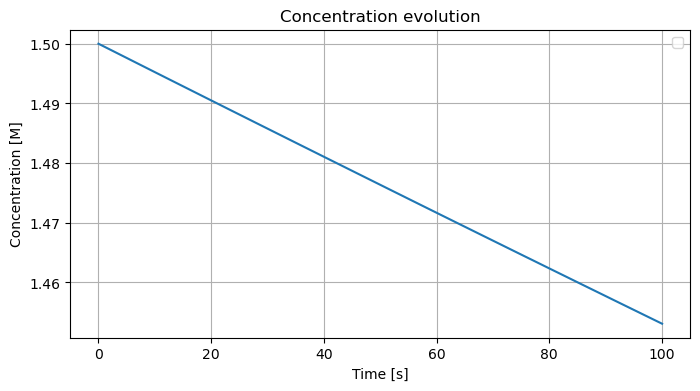

In [8]:
plot_concentration_evolution(c_numerical, times_numerical)

## 4. Diffusion experiments with two extremes

### 4.1. Slow release from full spore volume

To establish whether the spore coverage has any significant effect on the diffusion of the inhibitor, the two extreme configurations: a single spore and a fully surrounded spore with 12 neighbours, are used in a high-resolution diffusion simulation, making the assumption of a homogeneosly distributed inhibitor in the spore volume. The usual time-frame of 4 hours is used.

In [ ]:
# Global parameters
D = 690.2 # microns^2/s
Ps_fit = 0.00026650290428171825 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.53 # x10^(-5)
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=false)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
# sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx + 0.5, false)  # with safety radius of 0.5
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx, false)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=false)
println("Numerical solution single spore: ", c_numerical_ms[end])

Spore radius in lattice units: 12.5
Using D = 690.2, Db = 3.5533720570895764e-5, Dcw = 1.7766860742795512e-5
D*dt/dx2 = 862.7499999999999, Db*dt/dx2 = 4.44171507136197e-5, Dcw*dt/dx2 = 2.2208575928494387e-5
Timescale for accuracy: 5.795421616922632e-5
Storage arrays allocated.
1.5299999713897705
Frame 1 saved.1.461599349975586
Frame 2 saved.1.3962712287902828
Frame 3 saved.1.3338621854782104
Frame 4 saved.1.2742440700531006
Frame 5 saved.1.2172925472259517
Frame 6 saved.1.162885308265686
Frame 7 saved.1.1109075546264648
Frame 8 saved.1.061248898506164
Frame 9 saved.1.0138124227523806
Frame 10 saved.0.9684923887252807
Frame 11 saved.0.9252014160156249
Frame 12 saved.0.8838457465171811
Frame 13 saved.0.8443401455879209
Frame 14 saved.0.8066028952598572
Frame 15 saved.0.7705462574958801
Frame 16 saved.0.7360965013504029
Frame 17 saved.0.7031956911087033
Frame 18 saved.0.6717648506164549
Frame 19 saved.0.64174085855484
Frame 20 saved.0.6130594015121459
Frame 21 saved.0.5856578350067138
Fra

Plotting frames: [1, 26, 51, 101]
1.5299999713897705


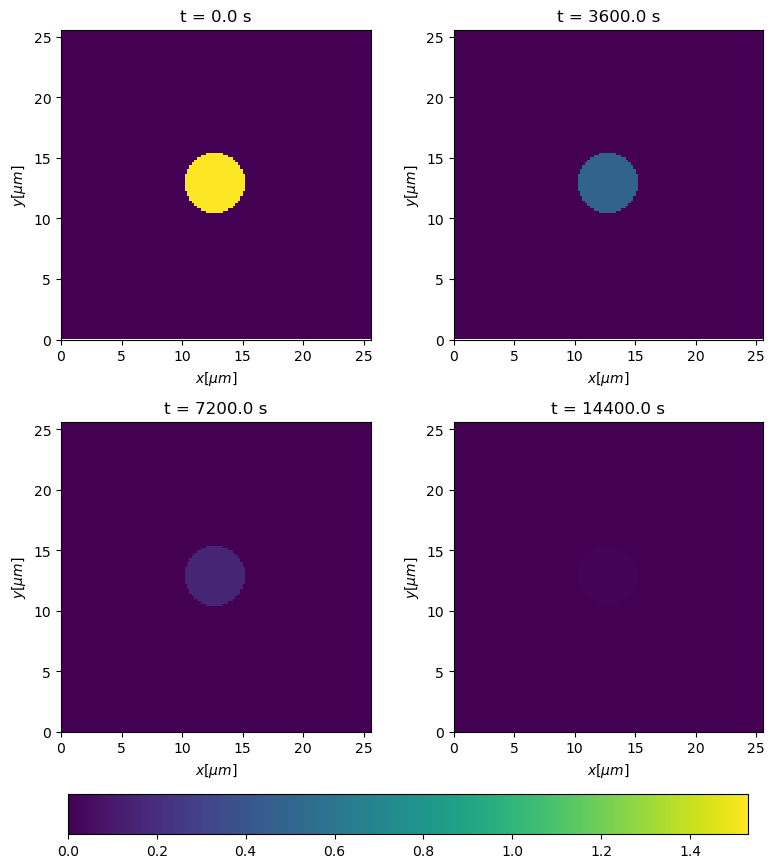

In [9]:
frame_indices = [1, 26, 51, 101]
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="")

Plotting frames: [1, 26, 51, 101]
1.5299999713897705


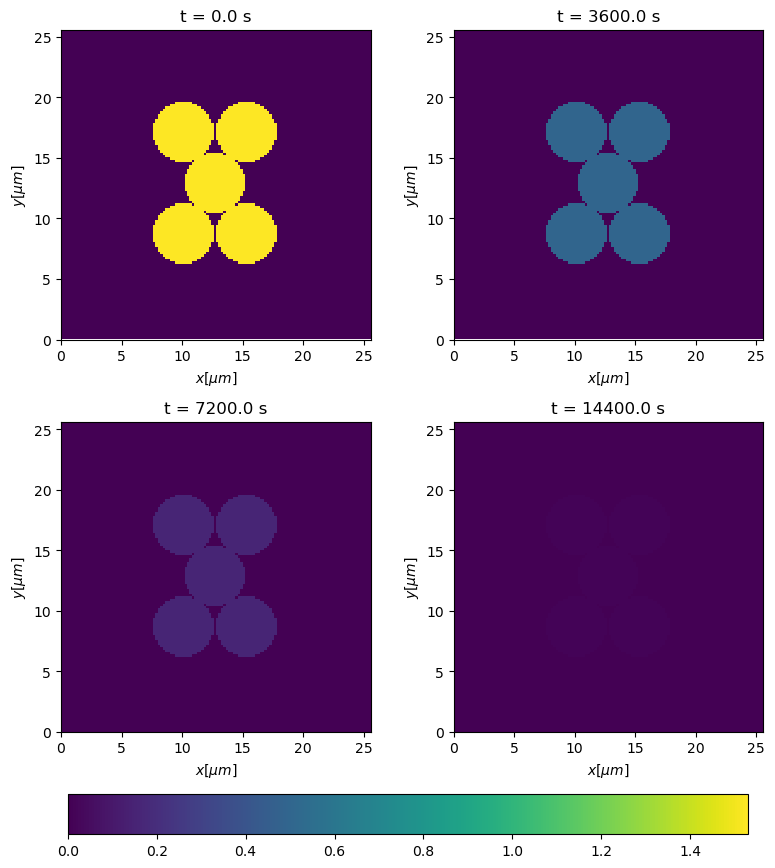

In [10]:
frame_indices = [1, 26, 51, 101]
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="")

0.015803130343556404
0.01700284704566002


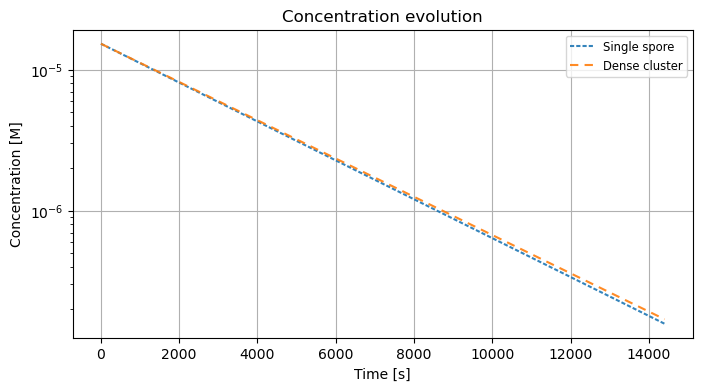

In [6]:
println(c_numerical_ss[end])
println(c_numerical_ms[end])
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms] .* 1e-5, [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=true)

It is evident that the complete surrounding of the spore by neighbours in direct contact with its cell wall only mildly slows down the inhibitor release, increasing the residual concentration at $t=4\ \textrm{h}$ by 7%. This suggests that the insufficient contact area of the spores, coupled with fast diffusion through the porous cavities in the cluster, only impose a weak diffusion limitation.

### 4.2. Slow release from the cell wall volume

As the interior of the spore has so far not been excluded from diffusion, it is possible that diffusion-limiting conidial cores become much more prominent obstacles in the dense cluster scenario. To test this, the previous experiment is repeated with inhibitor only included in the cell wall, with the rest of the spore being inaccessible for diffusion.

In [ ]:
# Global parameters
D = 690.2 # microns^2/s
Ps_fit = 0.00026650290428171825 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.53 # x10^(-5)
c0_cw = 20 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss2, c_numerical_ss2, times_numerical_ss2, region_ids_ss2, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=true)
println("Numerical solution single spore: ", c_numerical_ss2[end])

# ===== Dense cluster simulation =====
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx, false)
c_frames_ms2, c_numerical_ms2, times_numerical_ms2, region_ids_ms2, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=true)
println("Numerical solution single spore: ", c_numerical_ms2[end])

Spore radius in lattice units: 12.5
Using D = 690.2, Db = 3.5533720570895764e-5, Dcw = 1.7766860742795512e-5
D*dt/dx2 = 862.7499999999999, Db*dt/dx2 = 4.44171507136197e-5, Dcw*dt/dx2 = 2.2208575928494387e-5
Timescale for accuracy: 5.795421616922632e-5
Storage arrays allocated.
20.00000023397924
Frame 1 saved.17.83335697266457
Frame 2 saved.15.901274383162383
Frame 3 saved.14.178579463450395
Frame 4 saved.12.642518991389325
Frame 5 saved.11.272813449510041
Frame 6 saved.10.05153930188676
Frame 7 saved.8.962580632217552
Frame 8 saved.7.991575978541294
Frame 9 saved.7.125789977054286
Frame 10 saved.6.353814497269082
Frame 11 saved.5.665430412278553
Frame 12 saved.5.051651270238388
Frame 13 saved.4.504368985730743
Frame 14 saved.4.016362574060743
Frame 15 saved.3.5812457454774704
Frame 16 saved.3.193265636602398
Frame 17 saved.2.847299962289232
Frame 18 saved.2.5388273949661992
Frame 19 saved.2.2637819297356923
Frame 20 saved.2.0185200358243756
Frame 21 saved.1.7998449607125824
Frame 22 sa

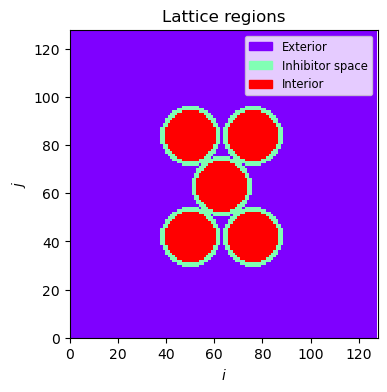

In [ ]:
plot_lattice_regions(region_ids_ms2)

Plotting frames: [26, 51, 76, 101]


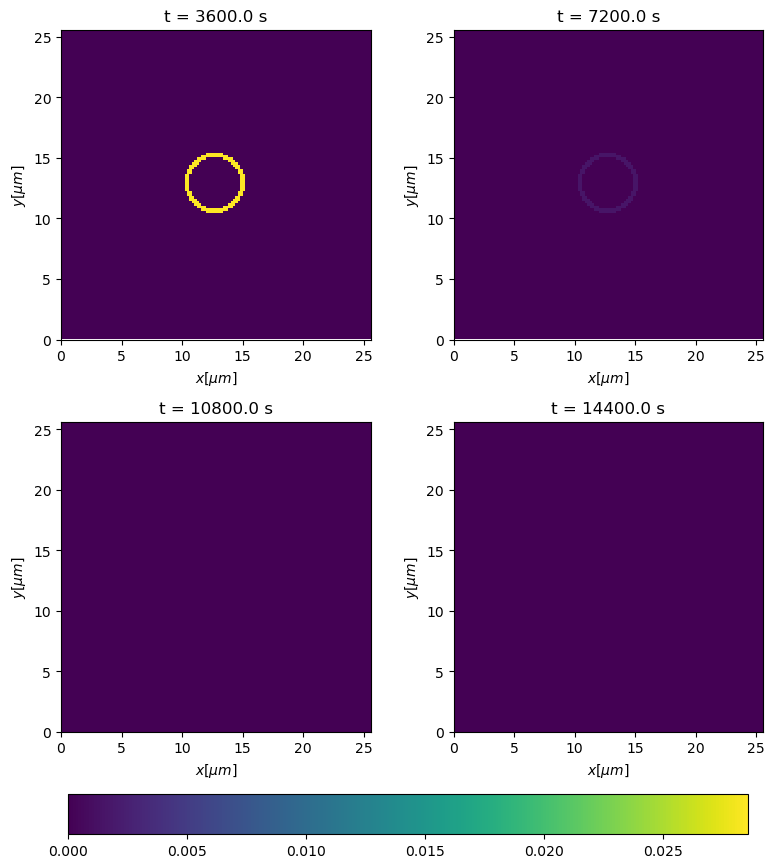

In [ ]:
frame_indices = [1, 26, 51, 101]
plot_concentration_lattice(c_frames_ss2, dx, frame_indices=frame_indices, times=times_numerical_ss2, title="")

[0, 25, 50, 100]
Plotting frames: [1, 26, 51, 101]


sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


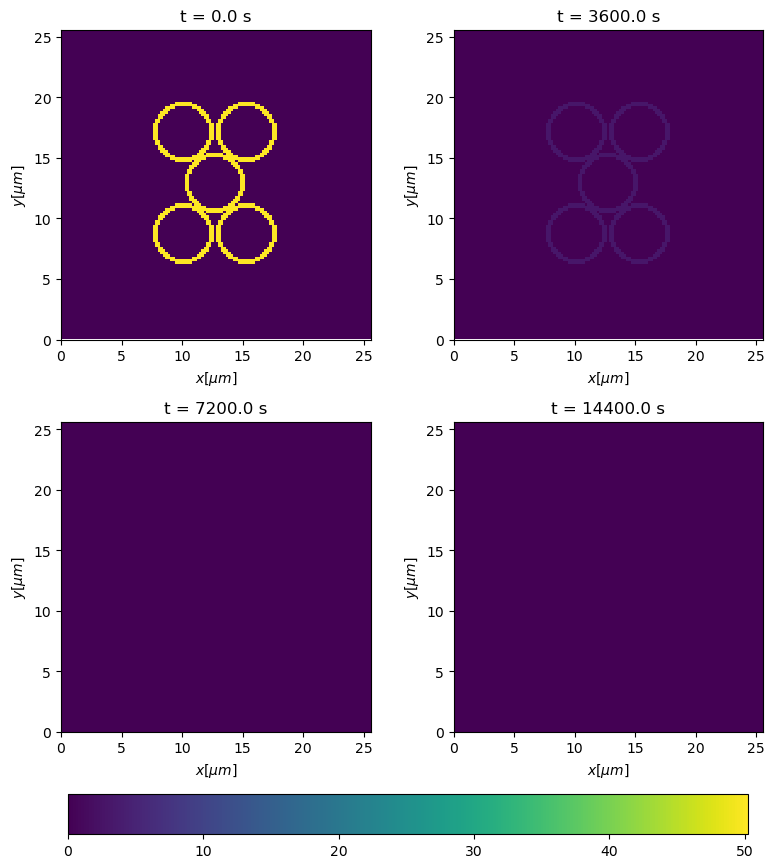

In [4]:
frame_indices = [1, 26, 51, 101]
println(frame_indices.-1)
# frame_indices = [1, 2]
plot_concentration_lattice(c_frames_ms2, dx, frame_indices=frame_indices, times=times_numerical_ms2, title="")

0.00020943261422076345
0.00025175127650859205


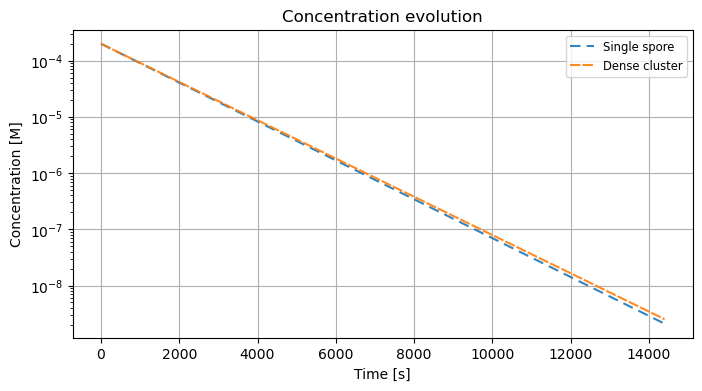

In [5]:
println(c_numerical_ss2[end])
println(c_numerical_ms2[end])
compare_concentration_evolutions([c_numerical_ss2, c_numerical_ms2] .* 1e-5, [times_numerical_ss2, times_numerical_ms2], ["Single spore", "Dense cluster"]; logy=true)

While the overall release is accelerated due to the increased concentration pressure in the smaller cell wall volume, the final concentration in the central spore of the cluster is about 20% higher than that of the single spore. This means that the excluded volumes play a role in limiting diffusion, albeit not a decisive one.

Plotting frames: [1, 26, 51, 101]
Plotting frames: [1, 26, 51, 101]
Plotting frames: [1, 26, 51, 101]
Plotting frames: [1, 26, 51, 101]


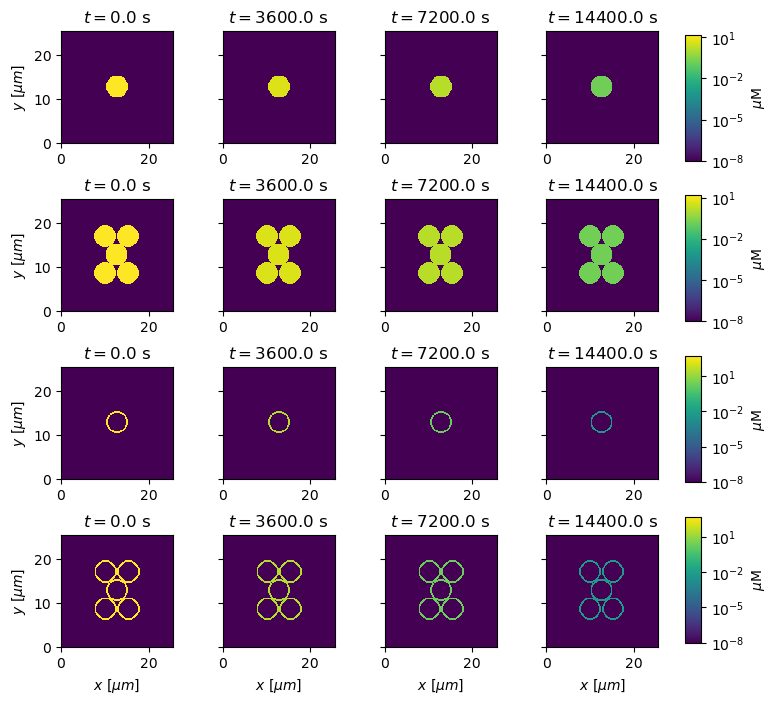

In [4]:
matplotlib.pyplot.close()
frame_indices = [1, 26, 51, 101]
compare_concentration_lattice([c_frames_ss, c_frames_ms, c_frames_ss2, c_frames_ms2].*10, [dx, dx, dx, dx]; frame_indices, times=times_numerical_ms, title="", lognorm=true)

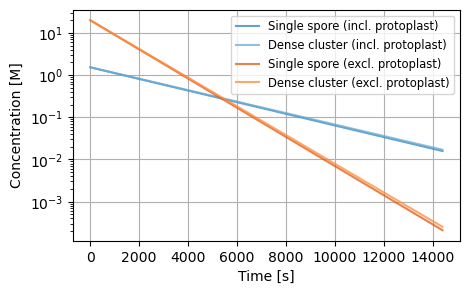

In [7]:
compare_concentration_evolution_groups([[c_numerical_ss, c_numerical_ms], [c_numerical_ss2, c_numerical_ms2]],
                                        [[times_numerical_ss, times_numerical_ms], [times_numerical_ss2, times_numerical_ms2]],
                                        [["Single spore (incl. protoplast)", "Dense cluster (incl. protoplast)"], ["Single spore (excl. protoplast)", "Dense cluster (excl. protoplast)"]]; logy=true)

### 4.3. Fast release from full spore volume

A relevant control experiment that can elucidate the role of spatial obstacles around the spore is to conduct analogical tests with disregard of the slow release, i.e. using the same diffusion coefficient within the medium and inside the cell wall. Since the absorbing boundary prohibits any finite-size saturation effects, a lingering concentration in the spore would indicate that the impermeable spore interiors have a severe limiting effect on the escape of inhibitor molecules. As the inhibitor of the uncovered spore is expected to diffuse fast, a time-frame of 1 second is observed.

In [ ]:
# Global parameters
D = 690.2 # microns^2/s
Ps_fit = 0.00026650290428171825 # microns/s
t_max = 1##14400#3600 # s
c0_spore = 1.53 # x10^(-5) M
c0_cw = 0.2 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.00001
Db = D # same as diffusion through medium
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=false)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx, false)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=false)
println("Numerical solution single spore: ", c_numerical_ms[end])

Spore radius in lattice units: 12.5
Using D = 600, Db = 400.0, Dcw = 300.0
D*dt/dx2 = 0.14999999999999997, Db*dt/dx2 = 0.09999999999999998, Dcw*dt/dx2 = 0.07499999999999998
Timescale for accuracy: 6.666666666666668e-5
Storage arrays allocated.
3.8399999141693115
Frame 1 saved.0.3696444408801026
Frame 2 saved.0.1407333953543868
Frame 3 saved.0.09527029348425117
Frame 4 saved.0.06449401233328496
Frame 5 saved.0.04365976618686064
Frame 6 saved.0.029555733035127797
Frame 7 saved.0.020008002245431256
Frame 8 saved.0.013544559456431599
Frame 9 saved.0.009169080781694731
Frame 10 saved.0.006207047175576129
Frame 11 saved.0.004201913160553369
Frame 12 saved.0.002844518480141945
Frame 13 saved.0.001925612964309336
Frame 14 saved.0.0013035590918180431
Frame 15 saved.0.0008824492371077795
Frame 16 saved.0.0005973813707947761
Frame 17 saved.0.000404400973497132
Frame 18 saved.0.0002737624778520268
Frame 19 saved.0.00018532504639991222
Frame 20 saved.0.00012545661667967347
Frame 21 saved.8.49283766

Plotting frames: [1, 2, 67, 101]


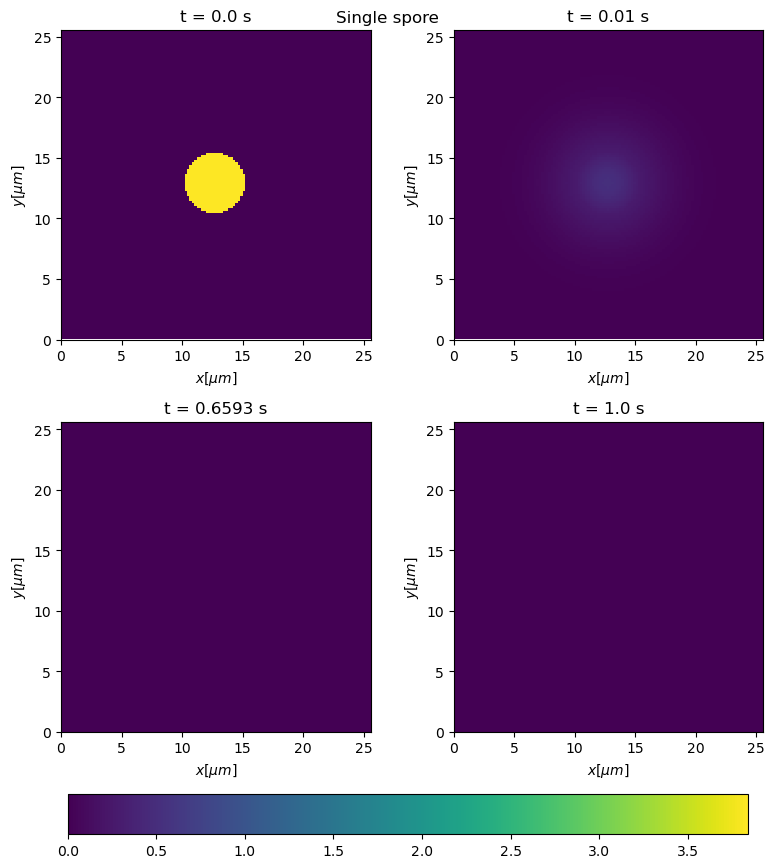

In [74]:
frame_indices = collect(round(Int, size(c_frames_ss)[1] / 3):round(Int, size(c_frames_ss)[1] / 3):size(c_frames_ss)[1]+1).-1
frame_indices[1] = 2
frame_indices = [1; frame_indices]
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="Single spore")

Plotting frames: [1, 2, 67, 101]


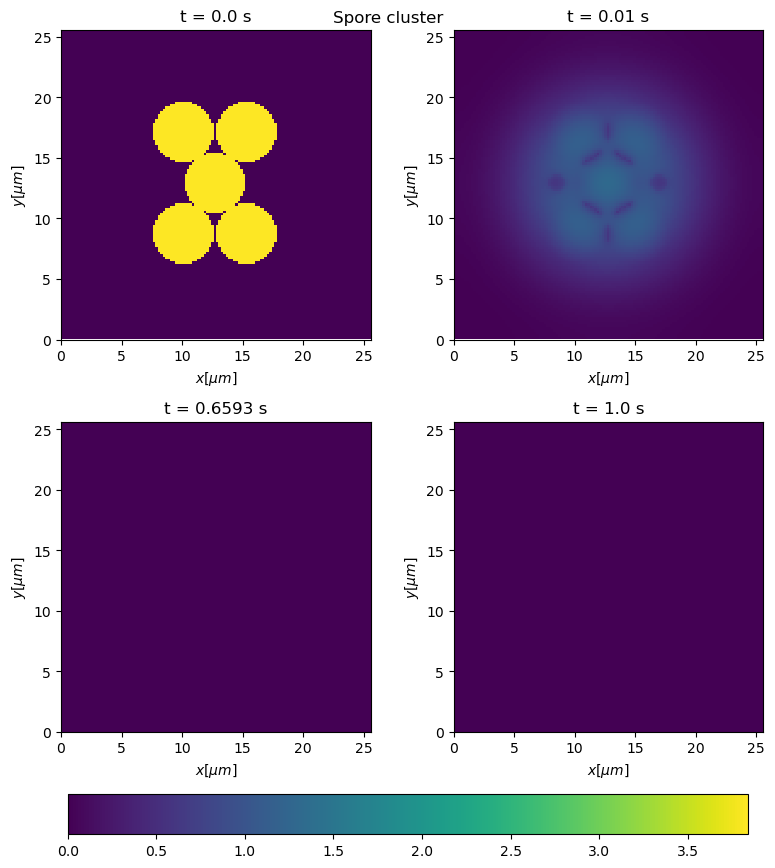

In [75]:
frame_indices = collect(round(Int, size(c_frames_ms)[1] / 3):round(Int, size(c_frames_ms)[1] / 3):size(c_frames_ms)[1]+1).-1
frame_indices[1] = 2
frame_indices = [1; frame_indices]
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="Spore cluster")

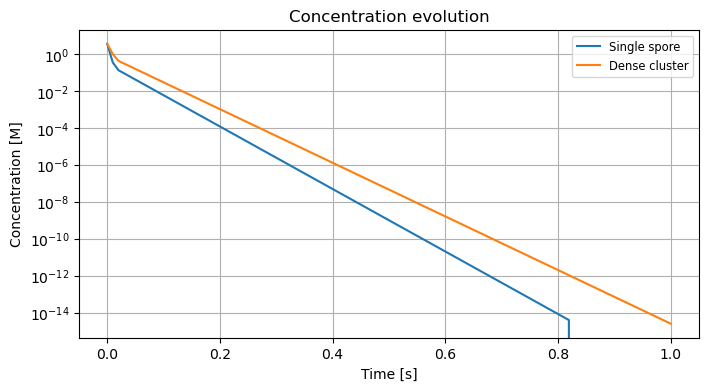

In [76]:
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms], [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=true, fit_exp=false)

In a fast-diffusing scenario, the obstruction by spore neighbours more distinctly slows down the release of the inhibitor, yielding a concentration equivalent to the single-spore case a fraction of a second later.

### 4.3. Fast release from cell wall volume

The experiment is repeated, as previously, using a diffusion-excluded interior and a concentration in the cell wall volume only.

In [68]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 1##14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.00001
Db = D # same as diffusion through medium
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=true)
# c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res!(copy(c_init), c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
#                                                                         D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, abs_bndry=true, empty_interior=true)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
# sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx + 0.5, false)  # with safety radius of 0.5
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx, false)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=true)
# c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res!(copy(c_init), c0_spore, sp_cen_indices, spore_diameter / 2, t_max;
#                                                                         D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, abs_bndry=true, empty_interior=true)
println("Numerical solution single spore: ", c_numerical_ms[end])

Spore radius in lattice units: 12.5
Using D = 600, Db = 400.0, Dcw = 300.0
D*dt/dx2 = 0.14999999999999997, Db*dt/dx2 = 0.09999999999999998, Dcw*dt/dx2 = 0.07499999999999998
Timescale for accuracy: 6.666666666666668e-5
Storage arrays allocated.
3.840000038847982
Frame 1 saved.0.08419887150118817
Frame 2 saved.0.04078628474888872
Frame 3 saved.0.027850407440144172
Frame 4 saved.0.019017318773004162
Frame 5 saved.0.012985701713195548
Frame 6 saved.0.00886711033234105
Frame 7 saved.0.006054773494792569
Frame 8 saved.0.0041344127849785315
Frame 9 saved.0.002823135680741759
Frame 10 saved.0.0019277496693173698
Frame 11 saved.0.0013163374347918962
Frame 12 saved.0.0008988393643433226
Frame 13 saved.0.0006137599767812183
Frame 14 saved.0.0004190981892855955
Frame 15 saved.0.000286175781728962
Frame 16 saved.0.00019541066221966956
Frame 17 saved.0.00013343352575085284
Frame 18 saved.9.111371140718133e-5
Frame 19 saved.6.2215853361295e-5
Frame 20 saved.4.248335966987588e-5
Frame 21 saved.2.90091

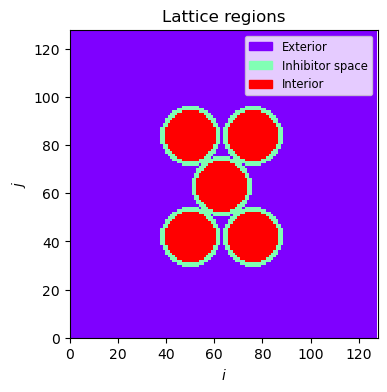

In [69]:
plot_lattice_regions(region_ids_ms)

Plotting frames: [1, 2, 67, 101]


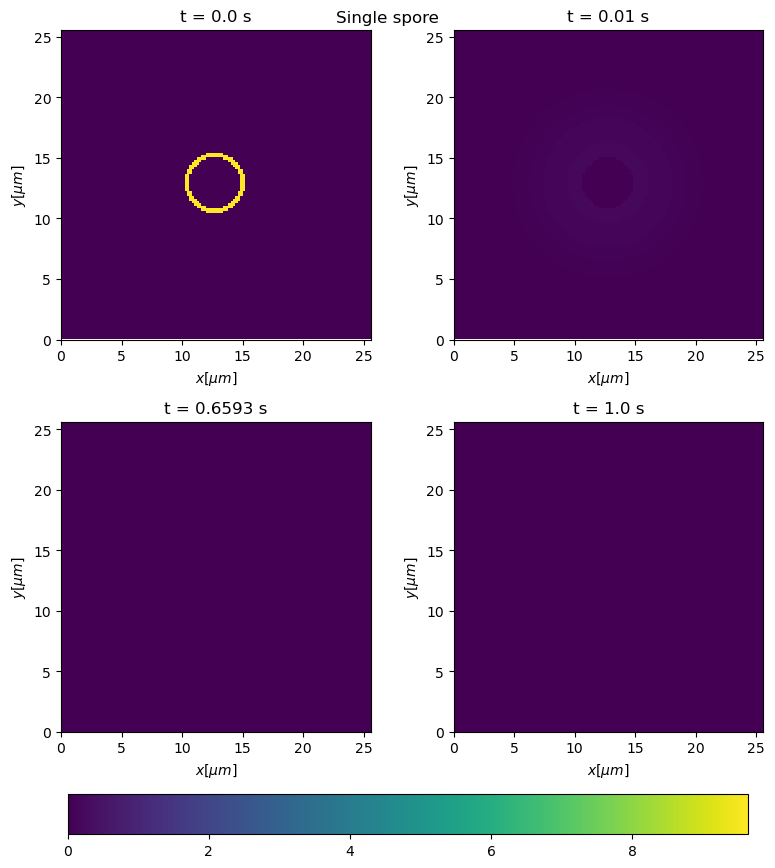

In [70]:
frame_indices = collect(round(Int, size(c_frames_ss)[1] / 3):round(Int, size(c_frames_ss)[1] / 3):size(c_frames_ss)[1]+1).-1
frame_indices[1] = 2
frame_indices = [1; frame_indices]
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="Single spore")

Plotting frames: [1, 2, 67, 101]


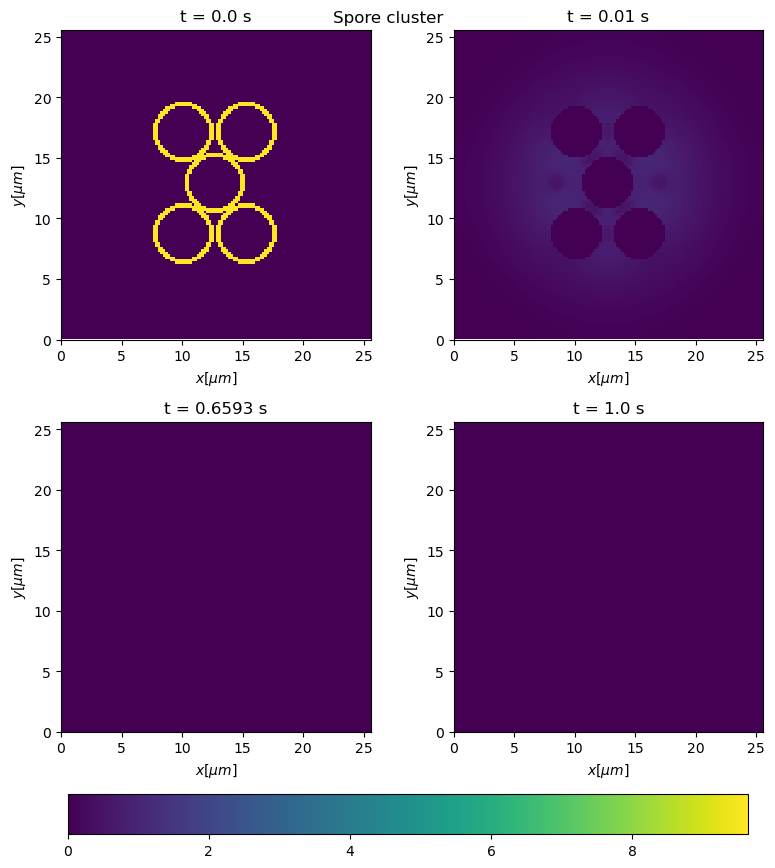

In [71]:
frame_indices = collect(round(Int, size(c_frames_ms)[1] / 3):round(Int, size(c_frames_ms)[1] / 3):size(c_frames_ms)[1]+1).-1
frame_indices[1] = 2
frame_indices = [1; frame_indices]
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="Spore cluster")

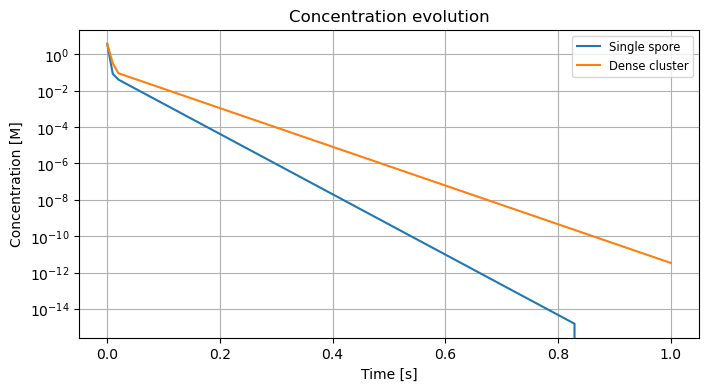

In [72]:
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms], [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=true, fit_exp=false)

The cluster with excluded spore interiors exhibits a more significantly decelerated the inhibitor release compared to the single spore. This means that the inaccessibility of the internal volumes has a more dramatic effect on diffusion blockage in clusters, despite the increased outward flow through the compactification of the inhibitor. Since this compartmentalisation of the spore volume is closer to a realistic scenario than a homogeneous distribution of the inhibitor in the spore, it is set up as the default mode in the upcoming experiments.

## 5. Invariance of neighbour positions

Since the coverage measure is independent of the ordering the neighbours around the central sphere, it is important to ascertain whether asymmetrical configurations have the same effect on the decay of spore concentrations as symmetrical ones with the same cluster size. Several comparisons are made:
- a linear array of 3 spores vs. triangular arrays resulting from a trimmed 4-spore cluster and a trimmed 5-spore tetrahedron;
- a tetrahedral array of 5 spores vs. a trimmed 9-spore cubic cluster;
- a cubic array of 9 spores vs. a trimmed 13-spore icosahedral cluster.

In [80]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
param_groups = [[(2, false), (3, true), (4, true)],
                [(4, false), (8, true)],
                [(8, false), (12, true)]]

c_groups = []
times_groups = []
# coverage_groups = []
for params in param_groups
    c_group = []
    times_group = []
    # coverage_group = []
    for (n_nbrs, trim) in params
        println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
        # sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx + 0.5, trim) # with safety radius of 0.5
        sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx, trim)
        sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
        c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true, empty_interior=true)
        push!(c_group, vec(c_numerical_ms))
        push!(times_group, vec(times_numerical_ms))
        # push!(coverage_group, measure_coverage(sp_cen_coords[1], sp_cen_coords[2:end], spore_rad))
    end
    push!(c_groups, c_group)
    push!(times_groups, times_group)
    # push!(coverage_groups, coverage_group)
end

Running simulation with 2 neighbours and trim: false
Spore radius in lattice units: 12.5
Using D = 600, Db = 3.567137426015758e-5, Dcw = 1.783568766026503e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 4.458921782519696e-5, Dcw*dt/dx2 = 2.2294609575331283e-5
Timescale for accuracy: 6.666666666666668e-5
Storage arrays allocated.
3.840000038847982
Frame 1 saved.3.4274564299456345
Frame 2 saved.3.0592386162859895
Frame 3 saved.2.7305769124750063
Frame 4 saved.2.4372122097119835
Frame 5 saved.2.1753739501722857
Frame 6 saved.1.941674555945283
Frame 7 saved.1.7330877831691052
Frame 8 saved.1.5469051454861378
Frame 9 saved.1.3807151226198293
Frame 10 saved.1.232386831037752
Frame 11 saved.1.0999891367709533
Frame 12 saved.0.9818189469395842
Frame 13 saved.0.8763428228795417
Frame 14 saved.0.7822000656276487
Frame 15 saved.0.6981660223825432
Frame 16 saved.0.6231623872782723
Frame 17 saved.0.5562155235998963
Frame 18 saved.0.4964609258697461
Frame 19 saved.0.44312717532450024
Frame 20 saved.0.3

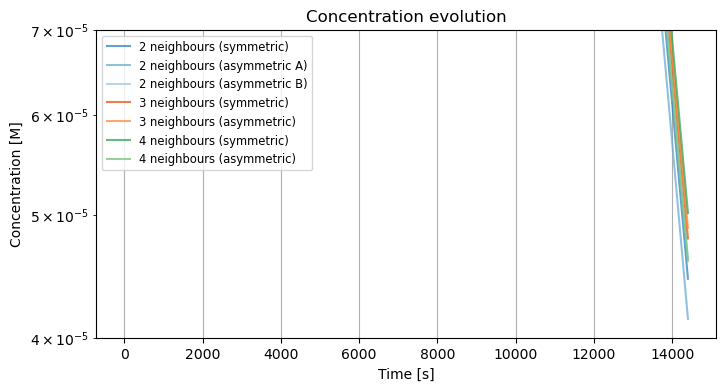

In [96]:
# c_groups = [[vec(c) for c in group] for group in c_groups]
# times_groups = [[vec(t) for t in group] for group in times_groups]
group_labels = [["2 neighbours (symmetric)", "2 neighbours (asymmetric A)", "2 neighbours (asymmetric B)"],
                ["3 neighbours (symmetric)", "3 neighbours (asymmetric)"],
                ["4 neighbours (symmetric)", "4 neighbours (asymmetric)"]]
# compare_concentration_evolution_groups(c_groups, times_groups, group_labels; logy=true, fit_exp=true)
compare_concentration_evolution_groups(c_groups, times_groups, group_labels; logy=true, fit_exp=false, ylim=(0.4e-4, 0.7e-4))

A very close look at the concentration curves indicates that the retaining of inhibitor is not invariant under neighbour symmetries. Instead, there is an indication that the more symmetric configurations are slightly more successful in blocking outward permeation. Therefore, an alternative measure should be established to capture the angular distribution of the neighbours around the central spore.

## 6. Neighbour distribution measure

So far it was shown that
- more neighbours result in a slower inhibitor release compared to less neighbours;
- isotropic clusters result in a slower inhibitor release compared to anisotropic clusters.

To obtain a measure that accounts for both of these effects, one can take the vectors $\vec{u}_i=\vec{r}_i-\vec{r}_\textrm{centre}$ connecting the $N$ neighbour centres to that of the central spore. Summing the outer products of these vectors, the unnormalised orientation tensor can be defined:

$$
\begin{equation}
\textbf{M}=\sum_{i=1}^{N}{\vec{u}_i\vec{u}_i^T}.
\end{equation}
$$

This is a $3\times 3$ real, symmetric and positive semi-definite matrix, which permits eigen-decomposition:

$$
\begin{equation}
\textbf{M}=\sum_{k=1}^{3}{\lambda_k\vec{v}_k\vec{v}_k^T},
\end{equation}
$$

where $\lambda_k$ are its eigenvalues and $\vec{v}_k$ its eigenvectors, such that

$$
\begin{equation}
\textbf{M}\vec{v}_k=\lambda_k\vec{v}_k.
\end{equation}
$$

As the elements in $\textbf{M}$ grow as more neighbours are added, so do the eigenvalues. If the neighbours are isotropically distributed around the central spore, the three eigenvalues would remain equal, i.e. the centre of mass would be evenly distributed. On the other hand, an asymmetry in the arrangement would yield a disbalance among the eigenvalues, with one of them dominating the others: $\lambda_1>\lambda_2>\lambda_3$. Since the two less dominant eigenvalues are only maximised in the isotropic scenario, they can be used to form a "shielding index":

$$
\begin{equation}
S=\lambda_1+\lambda_2.
\end{equation}
$$

This index is used in the upcoming experiments as an improved measure to which the release exponents can be mathematically related.

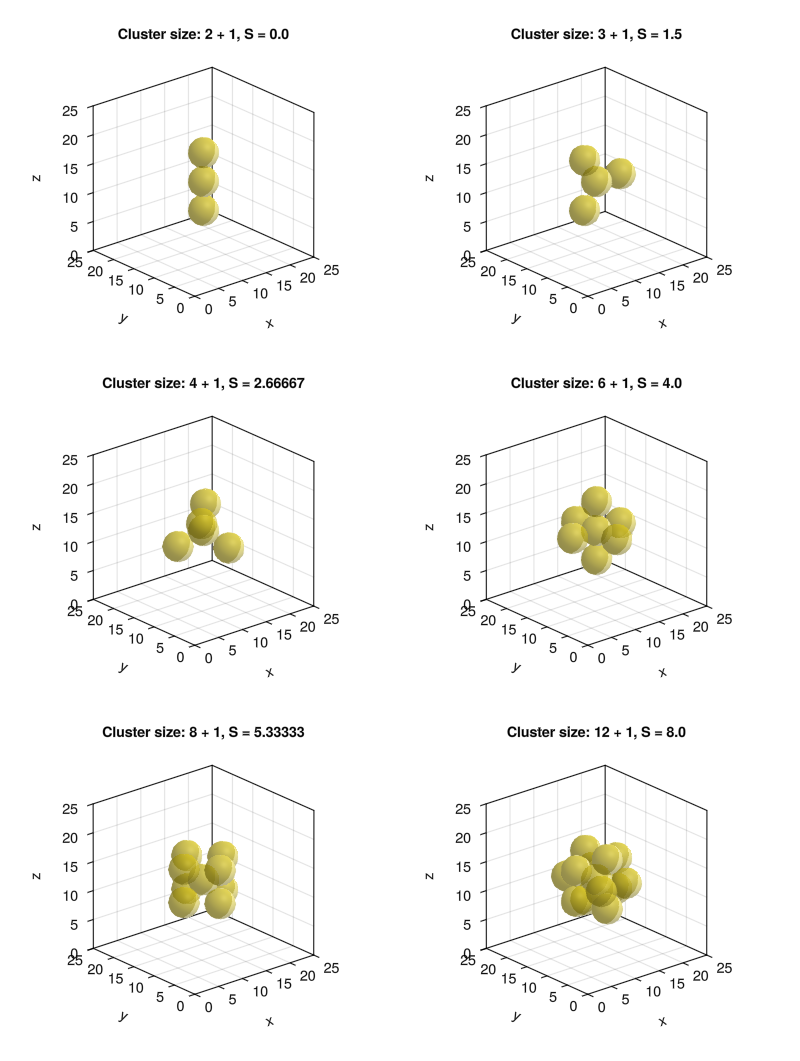

GLMakie.Screen(...)

In [4]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

n_nbrs = [2, 3, 4, 6, 8, 12]

plot_spore_clusters(n_nbrs, spore_rad, L, measure_shielding=true)

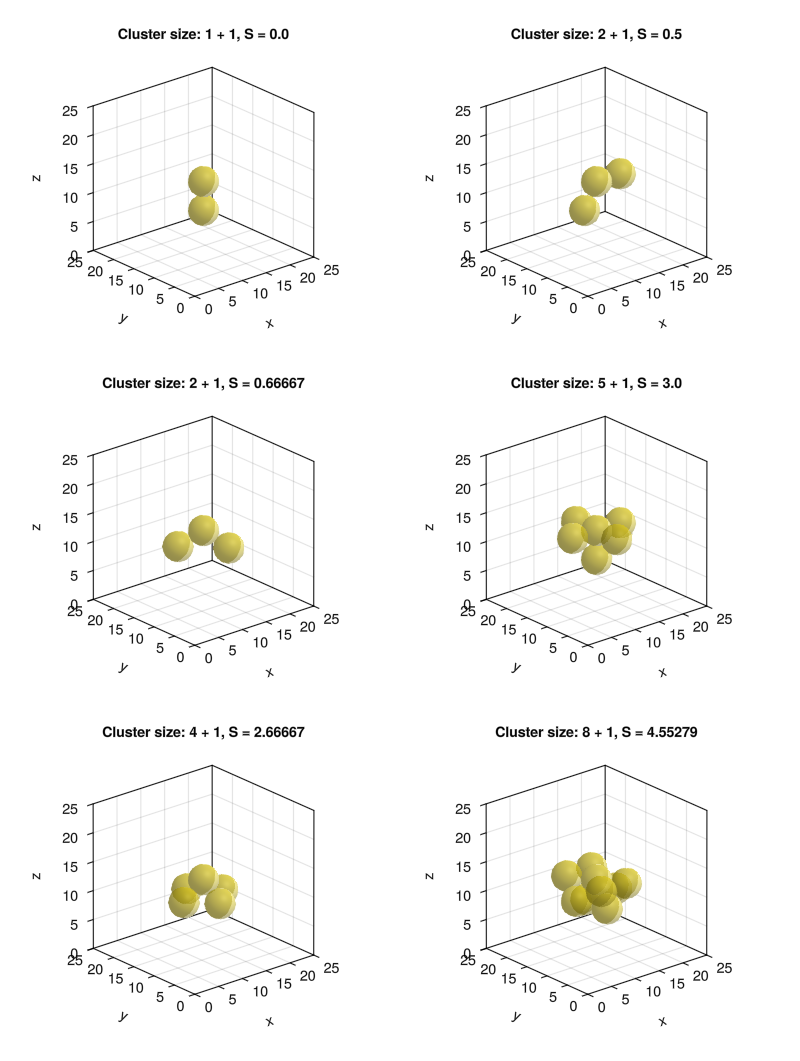

GLMakie.Screen(...)

In [5]:
plot_spore_clusters(n_nbrs, spore_rad, L; cut_half=true, measure_shielding=true)

## 7. Functional relationship between spore coverage and decay exponent

With the important recognition that only the number of adjacent neighbours affects the concentration decay and that the fucntion of this decay is exponential, full and half cluster sizes of all available integers are simulated. The coverage measure and the resulting decay are recorded to obtain a functional relationship between them.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
param_set = [(2, true), (3, true), (4, true), (2, false), (3, false), (8, true), (4, false), (6, true), (6, false), (12, true), (8, false), (12, false)]

coverages = [0.0]
nbr_nums = [0]
exponents = []

# Run single spore simulation
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_rad, t_max;
                                                                                                    D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                    crank_nicolson=false, abs_bndry=true)
fit = exp_fit(times_numerical, c_numerical)
push!(exponents, fit[2])

# Run spore cluster simulations
for (n_nbrs, trim) in param_set
    println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
    # sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx + 0.5, trim) # with safety radius of 0.5
    sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx, trim)
    push!(nbr_nums, length(sp_cen_indices) - 1)
    sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
    c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, sp_cen_indices, spore_rad, t_max;
                                                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                        crank_nicolson=false, abs_bndry=true)
    push!(coverages, measure_shielding_index(sp_cen_coords[1], sp_cen_coords[2:end]))
    fit = exp_fit(times_numerical, c_numerical)
    push!(exponents, fit[2])
end

Spore radius in lattice units: 12.5
Using D = 600, Db = 3.567137426015758e-5, Dcw = 1.783568766026503e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 4.458921782519696e-5, Dcw*dt/dx2 = 2.2294609575331283e-5
Timescale for accuracy: 6.666666666666668e-5
Storage arrays allocated.
3.840000038847982
Frame 1 saved.3.422471804907247
Frame 2 saved.3.0503702673204653
Frame 3 saved.2.7187125099333476
Frame 4 saved.2.423123979330556
Frame 5 saved.2.1596683559299343
Frame 6 saved.1.9248534401388402
Frame 7 saved.1.7155770376910398
Frame 8 saved.1.5290385723636288
Frame 9 saved.1.362792061384075
Frame 10 saved.1.2146158604867356
Frame 11 saved.1.082556240457361
Frame 12 saved.0.9648550443729373
Frame 13 saved.0.8599494027876718
Frame 14 saved.0.7664456257814906
Frame 15 saved.0.6831145984667764
Frame 16 saved.0.6088383783602984
Frame 17 saved.0.5426426167120764
Frame 18 saved.0.4836431084083092
Frame 19 saved.0.4310596529201708
Frame 20 saved.0.38418913937926474
Frame 21 saved.0.34241860055337353
Fram

It is known that, given fast diffusion in the surrounding medium, the concentration in an uncovered spore decreases exponentially as $\sim e^{-t/\tau}$. A logical assumption is that the presence of adjacent spores modulate this decay with a factor $a$ as $\sim e^{-at/\tau}$. To neutralise the role of $\tau$ in the analysis, the measured exponents are multiplied by $-\tau$ in order to obtain the sole contribution of the spore coverage.

Fitted power: (2.4675949370523313, -0.004356016728201526)


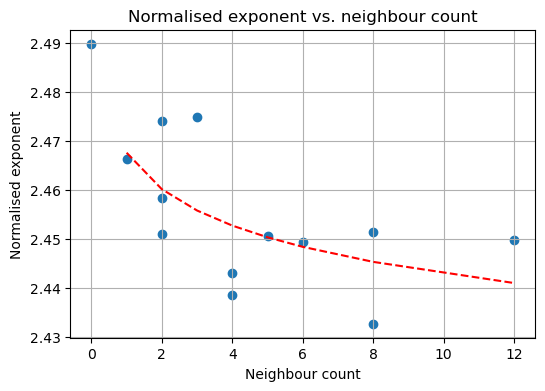

In [19]:
# Normalise exponents with tau
V_spore = 4/3 * π * spore_rad^3
A_spore = 4 * π * spore_rad^2
tau = V_spore / (Ps_fit * A_spore)
exp_norm = -exponents .* tau

plot_functional_relationship(nbr_nums, exp_norm, ["Neighbour count", "Normalised exponent"], "Normalised exponent vs. neighbour count", fit="pow", scatter=true)

The relationship between neighbour count and decay exponent appears quite noisy, but a general decrease can be noticed with the addition of new neighbours. An atttempt to fit a power-law through the relationship shows an exponent of approximately $-0.044$.

It has to be noted that the excluded spore interior creates a further gap between the numerical model and the simple permeation formula, so the baseline increase of the normalised exponent is partly due to the increased concentration pressure in the constricted cell wall volume. To get rid of this effect, the experiment is repeated for the full-volume scenario.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
param_set = [(2, true), (3, true), (4, true), (2, false), (3, false), (8, true), (4, false), (6, true), (6, false), (12, true), (8, false), (12, false)]

coverages = [0.0]
nbr_nums = [0]
exponents = []

# Run single spore simulation
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_rad, t_max;
                                                                                                    D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                    crank_nicolson=false, abs_bndry=true, empty_interior=false)
fit = exp_fit(times_numerical, c_numerical)
push!(exponents, fit[2])

# Run spore cluster simulations
for (n_nbrs, trim) in param_set
    println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
    # sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx + 0.5, trim) # with safety radius of 0.5
    sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx, trim)
    push!(nbr_nums, length(sp_cen_indices) - 1)
    sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
    c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, sp_cen_indices, spore_rad, t_max;
                                                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                        crank_nicolson=false, abs_bndry=true, empty_interior=false)
    push!(coverages, measure_shielding_index(sp_cen_coords[1], sp_cen_coords[2:end]))
    fit = exp_fit(times_numerical, c_numerical)
    push!(exponents, fit[2])
end

Spore radius in lattice units: 12.5
Using D = 600, Db = 3.567137426015758e-5, Dcw = 1.783568766026503e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 4.458921782519696e-5, Dcw*dt/dx2 = 2.2294609575331283e-5
Timescale for accuracy: 6.666666666666668e-5
Storage arrays allocated.
3.8399999141693115
Frame 1 saved.3.6680815219879146
Frame 2 saved.3.5038344860076895
Frame 3 saved.3.346954345703125
Frame 4 saved.3.197077751159668
Frame 5 saved.3.0539577007293697
Frame 6 saved.2.917207717895508
Frame 7 saved.2.7866063117980966
Frame 8 saved.2.661852359771729
Frame 9 saved.2.5426697731018066
Frame 10 saved.2.4288227558135986
Frame 11 saved.2.3200697898864746
Frame 12 saved.2.216197252273559
Frame 13 saved.2.1169638633728027
Frame 14 saved.2.0221896171569824
Frame 15 saved.1.9316560029983516
Frame 16 saved.1.845164656639099
Frame 17 saved.1.762553930282593
Frame 18 saved.1.6836318969726565
Frame 19 saved.1.6082504987716675
Frame 20 saved.1.5362313985824585
Frame 21 saved.1.467452526092529
Frame 22 

Fitted power: (0.9813041584910794, -0.004244510895986831)


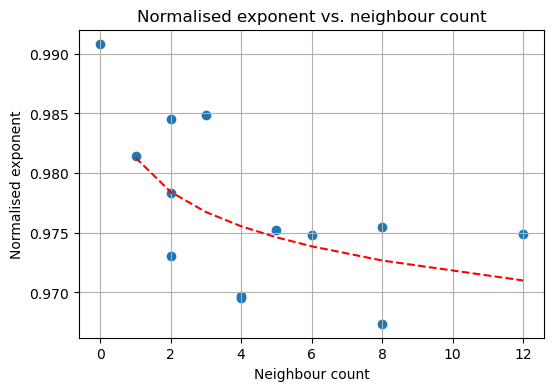

In [29]:
# Normalise exponents with tau
V_spore = 4/3 * π * spore_rad^3
A_spore = 4 * π * spore_rad^2
tau = V_spore / (Ps_fit * A_spore)
exp_norm = -exponents .* tau

plot_functional_relationship(nbr_nums, exp_norm, ["Neighbour count", "Normalised exponent"], "Normalised exponent vs. neighbour count", fit="pow", scatter=true)

The relationship between the measured exponents and the neighbourhood counts follow a similar noisy pattern as in the hollow-core simulations, but the exponents are scaled such that the fastest release (in the single spore scenario) lies slightly below 1. This deviation from the expected normalised exponent of 1 could be explained by the slow diffusion in the spore interior, which does not allow for an immediate mixing of the internal concentrations at each step - an assumption which was held in the simpler models.

## 7. Role of neighbour distance

All experiments so far looked into directly adjacent neighbour spores. As the coverage measure also accounts for the distance between neighbour surfaces, a relevant question is how much the blocking effect diminishes with distance. To examine this, two experiments are conducted - one with a single neighbour spore and one with a fully packed 12-neighbour configuration. In both cases, the centre-to-centre distance between the central spore and the neighbours is gradually increased from $2R$ to $3R$ on a lattice of size $256\times0.2 \mu m$.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1

# Lattice parameters
N = 256
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 10

# Simulation parameters (neighbours, trim)
param_set = [(2, true), (12, false)]
distances = collect(1:0.25:1.5) * spore_diameter

# Run spore cluster simulations
c_groups = []
c_frame_groups = []
times_groups = []
coverage_groups = []
exponent_groups = []
distance_groups = []
for (n_nbrs, trim) in param_set
    c_group = []
    c_frame_group = []
    times_group = []
    coverage_group = []
    exponent_group = []
    distance_group = []
    for dist in distances
        println("Running simulation with $(n_nbrs) neighbours and trim: $(trim), at distance: $(dist)")
        
        sp_cen_indices = setup_spore_cluster(n_nbrs, N, 0.5 * dist / dx, trim)
        sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
        push!(coverage_group, measure_shielding_index(sp_cen_coords[1], sp_cen_coords[2:end]))

        c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(copy(c_init), c0_spore, sp_cen_indices, spore_rad, t_max;
                                                                                                            D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                            crank_nicolson=false, abs_bndry=true, empty_interior=true)
        push!(c_group, vec(c_numerical))
        push!(c_frame_group, c_frames)
        push!(times_group, vec(times_numerical))
        fit = exp_fit(times_numerical, c_numerical)
        push!(exponent_group, fit[2])
        push!(distance_group, dist)
    end
    push!(c_groups, vec(c_group))
    push!(c_frame_groups, c_frame_group)
    push!(times_groups, vec(times_group))
    push!(coverage_groups, coverage_group)
    push!(exponent_groups, exponent_group)
    push!(distance_groups, distance_group)
end

Running simulation with 2 neighbours and trim: true, at distance: 5.0
Spore radius in lattice units: 12.5
Using D = 600, Db = 3.567137426015758e-5, Dcw = 1.783568766026503e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 4.458921782519696e-5, Dcw*dt/dx2 = 2.2294609575331283e-5
Timescale for accuracy: 6.666666666666668e-5
Storage arrays allocated.
1.4999999795732408
Frame 1 saved.0.47965552230320585
Frame 2 saved.0.1533819602849319
Frame 3 saved.0.04904777428899874
Frame 4 saved.0.01568424802518781
Frame 5 saved.0.0050154543014009085
Frame 6 saved.0.0016038224007673646
Frame 7 saved.0.000512862615210232
Frame 8 saved.0.0001640008730800033
Frame 9 saved.5.2443553721474426e-5
Frame 10 saved.Running simulation with 2 neighbours and trim: true, at distance: 6.25
Spore radius in lattice units: 12.5
Using D = 600, Db = 3.567137426015758e-5, Dcw = 1.783568766026503e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 4.458921782519696e-5, Dcw*dt/dx2 = 2.2294609575331283e-5
Timescale for accuracy: 6.666666

Fitted exponential: (1.4999808121706883, -0.0007917613325449513)
Fitted exponential: (1.499994676303245, -0.0007993394522290096)
Fitted exponential: (1.4999903179884784, -0.0007993397964573648)
Fitted exponential: (1.500002272479166, -0.0007865057187585656)
Fitted exponential: (1.4999880410348694, -0.0007993396708335032)
Fitted exponential: (1.4999937634585627, -0.0007993396160817053)


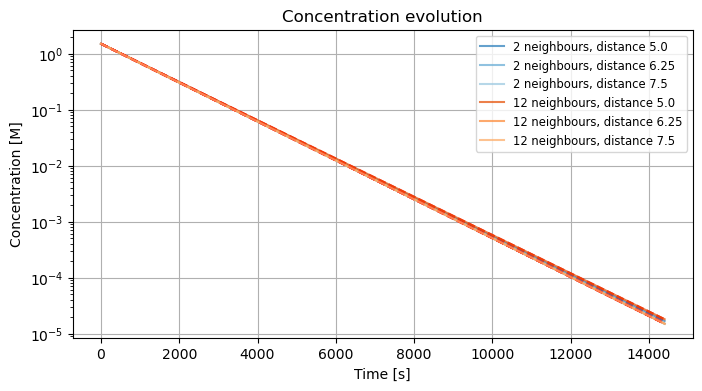

In [3]:
c_groups_vec = [[vec(c) for c in group] for group in c_groups]
times_groups_vec = [[vec(t) for t in group] for group in times_groups]
group_labels = [["2 neighbours, distance $dist" for dist in distances], ["12 neighbours, distance $dist" for dist in distances]]	
compare_concentration_evolution_groups(c_groups_vec, times_groups_vec, group_labels; logy=true, fit_exp=true)
# compare_concentration_evolution_groups([c_groups_vec[1][1:3]], [times_groups_vec[1][1:3]], [group_labels[1][1:3]]; logy=true, fit_exp=true)

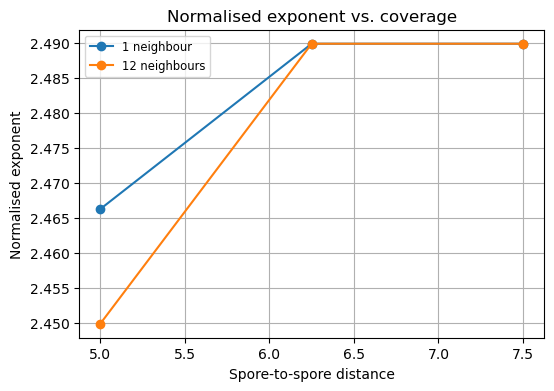

In [5]:
# Normalise exponents with tau
V_spore = 4/3 * π * spore_rad^3
A_spore = 4 * π * spore_rad^2
tau = V_spore / (Ps_fit * A_spore)
exp_norm_groups = [-exponent_group .* tau for exponent_group in exponent_groups]

compare_functional_relationships(distance_groups, exp_norm_groups, ["Spore-to-spore distance", "Normalised exponent"], ["1 neighbour", "12 neighbours"], "Normalised exponent vs. coverage")#, fit="pow")

The results show that the obstructing effect of neighbours immediately disappears as soon as the neighbours lose contact with the central spore. Thus, an appropriate measure of spore clustering does not need to account for the distance of neighbours to the measured spore, only for the number of neighbours.